In [3]:
import nrrd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.linear_model import LinearRegression
from scipy.special import comb

In [4]:
IMAGE_PATHS = ['./001/Volume_ID_47383217.nrrd', 
               './002/Volume_ID_40ed7f97.nrrd', 
               './003/Volume_ID_2b0fd57d.nrrd', 
               './004/Volume_ID_24708241.nrrd']

SEGMENTATION_PATHS = ['./001/ID_47383217_segmentation.seg.nrrd', 
                      './002/ID_40ed7f97_segmentation.seg.nrrd', 
                      './003/ID_2b0fd57d_segmentation.seg.nrrd',
                      './004/ID_24708241_segmentation.seg.nrrd']

# Prepare and visualize image with segmentation

In [5]:
# --- Create color-coded overlay containing segmentation data
def create_segmentation_overlay(segmentation, slice_index):
    colors = {
            0: [0, 0, 0, 0],        # Background (transparent)
            1: [0, 255, 0, 128],    # Anterior falx (green)
            2: [255, 255, 0, 128],    # Posterior falx (yellow)
            3: [255, 165, 0, 128],    # Septum pellucidum (orange)
        }
    # segmentation=np.transpose(segmentation, (1,0,2))
    segmentation_slice = segmentation[:,:,slice_index]
    overlay = np.zeros((segmentation_slice.shape[0], segmentation_slice.shape[1], 4), dtype=np.uint8)
    for label, color in colors.items():
        mask = segmentation_slice == label
        overlay[mask] = color
    return overlay

# --- Intermediate function used to plot a specified slice of image + segmentation
def plot_slices(slice_index, image, segmentation):
    
    image = np.transpose(image, (1,0,2))
    
    overlay = create_segmentation_overlay(segmentation, slice_index)
    overlay = np.transpose(overlay, (1,0,2))
    
    plt.figure(figsize=(8,8))
    plt.imshow(image[:, :, slice_index], cmap='gray', clim=(0,100))
    plt.imshow(overlay, alpha=0.5)
    plt.title(f"Slice at z = {slice_index}")

# --- Interactive function to slide through image with overlayed segmentation
def imshow(image, segmentation):
    slice_slider = widgets.IntSlider(min=0, max=image.shape[2]-1, step=1, value=0, description='Slice')
    widgets.interact(plot_slices, slice_index=slice_slider, image=fixed(image), segmentation=fixed(segmentation))

# Define visualization functions for line overlay on image

In [6]:
# --- Same as plot_slices, but overlay the intersection of the plane with the image at a specific slice
def plot_slices_with_line_overlay(slice_index, image, segmentation, plane):
    A, B, C, D = plane
    # Equation of plane is given by Ax + By + Cz + D = 0
    # So x = -(By+Cz+D)/A
    # We will find points (x0, 0, slice_index) and (x1, 511, slice_index) and draw a line through them (assuming image is 512 x 512)
    x0 = -(B * 0 + C * slice_index + D)/A
    x1 = -(B * 511 + C * slice_index + D)/A

    plot_slices(slice_index, image, segmentation)   # re-using previous function
    plt.plot([x0, x1], [0, 511], color='red')    # adding line

# --- Interactive function, same as imshow but add intersection of specified plane equation at each slice
def imshow_with_line_overlay(image, segmentation, plane):
    slice_slider = widgets.IntSlider(min=0, max=image.shape[2]-1, step=1, value=0, description='Slice')
    widgets.interact(plot_slices_with_line_overlay, slice_index=slice_slider, image=fixed(image), segmentation=fixed(segmentation), plane=fixed(plane))

# Fit a plane through all points while omitting z coordinates (so plane is orthogonal to xy axis) (Linear Regression) (approach 1)

In [16]:
def fit_orthogonal_plane(segmentation):
    anterior_falx = np.argwhere(segmentation==1)
    posterior_falx = np.argwhere(segmentation==2)
    combined_falx = np.vstack((anterior_falx, posterior_falx))
    x_points = combined_falx[:,0].reshape(-1,1)
    y_points = combined_falx[:,1].reshape(-1,1)
    reg = LinearRegression().fit(x_points, y_points)
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    
    # plane Ax + By + Cz + D = 0
    A = a
    B = -1
    C = 0
    D = b
    plane = (A, B, C, D)
    return plane

# Fit a plane through all points while considering z coordinates (SVD) (approach 2)

In [17]:
def fit_non_orthogonal_plane(segmentation):
    anterior_falx = np.argwhere(segmentation==1)
    posterior_falx = np.argwhere(segmentation==2)
    combined_falx = np.vstack((anterior_falx, posterior_falx))
    
    mean_point = np.mean(combined_falx, axis=0)
    centered_points = combined_falx - mean_point
    U, S, Vt = np.linalg.svd(centered_points)
    normal_vector = Vt[-1]
    
    A, B, C = normal_vector
    D = -np.dot(normal_vector, mean_point)
    
    plane = (A, B, C, D)
    return plane

# Compute and visualize midline shift 

In [21]:
# Distance between point = (x0, y0) and line of equation ax+by+c=0 is given by abs(a * x0 + b*yo + c) / sqrt(a**2 + b**2)
def distance_point_to_line(plane, point):
    x0, y0, z0 = point
    A,B,C,D = plane

    # Eq of plane is: Ax + By + Cz + D = 0
    # Thus, eq of line at z = z0 is: Ax + By + (Cz0 + D) = 0
    distance = abs(A * x0 + B * y0 + (C*z0 + D)) / np.sqrt(A**2 + B**2)
    x_closest = x0 - A * (A * x0 + B * y0 + (C*z0 + D)) / (A**2 + B**2)
    y_closest = y0 - B * (A * x0 + B * y0 + (C*z0 + D)) / (A**2 + B**2)
    closest_point = (x_closest, y_closest)
    distance = distance*0.5 # account for spacing of voxels
    return distance, closest_point

def midline_shift_plot(image, segmentation, plane, closest_point, sp, distance):
    spx, spy, spz = sp
    clpx, clpy = closest_point
    plot_slices_with_line_overlay(int(spz), image, segmentation, plane)
    plt.plot(spx, spy, 'bo')
    plt.plot(clpx, clpy, 'go')
    plt.plot([spx, clpx], [spy, clpy], color='yellow', linestyle='--')
    plt.text(spx, spy-5, f'{distance:.3f}', color='yellow', size=8)
    plt.title(f"Slice at z = {int(spz)}")

# Implement as global post-processing (USES APPROACH 1 FOR NOW)

In [22]:
def calculate_midline_shift(n):
    # read image and segmentation
    ct_image, ct_image_header = nrrd.read(IMAGE_PATHS[n])
    segmentation, segmentation_header = nrrd.read(SEGMENTATION_PATHS[n])
    
    plane = fit_orthogonal_plane(segmentation)
    A,B,C,D = plane
    print(f"Plane equation: {A:.2f}x + {B:.2f}y + {C:.2f}z + {D:.2f} = 0")

    imshow_with_line_overlay(ct_image, segmentation, plane)

    septum_pellucidum = np.argwhere(segmentation==3)
    sp = np.mean(septum_pellucidum, axis=0)
        
    distance, closest_point = distance_point_to_line(plane, sp)
    midline_shift_plot(ct_image, segmentation, plane, closest_point, sp, distance)

Plane equation: -13.51x + -1.00y + 0.00z + 4633.11 = 0


interactive(children=(IntSlider(value=0, description='Slice', max=30), Output()), _dom_classes=('widget-intera…

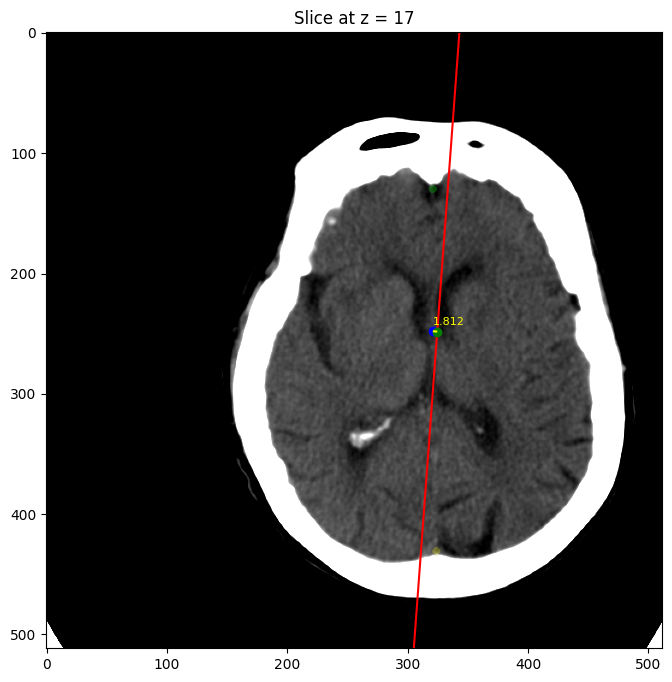

In [23]:
calculate_midline_shift(0)

In [24]:
def calculate_midline_shift_mlsplotonly(n):
    # read image and segmentation
    ct_image, ct_image_header = nrrd.read(IMAGE_PATHS[n])
    segmentation, segmentation_header = nrrd.read(SEGMENTATION_PATHS[n])
    
    plane = fit_orthogonal_plane(segmentation)
    A,B,C,D = plane

    septum_pellucidum = np.argwhere(segmentation==3)
    sp = np.mean(septum_pellucidum, axis=0)
        
    distance, closest_point = distance_point_to_line(plane, sp)
    midline_shift_plot(ct_image, segmentation, plane, closest_point, sp, distance)

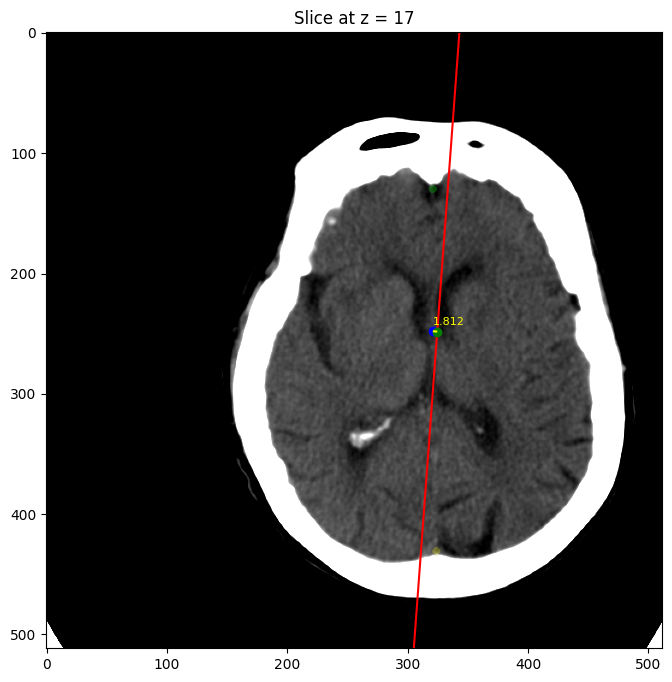

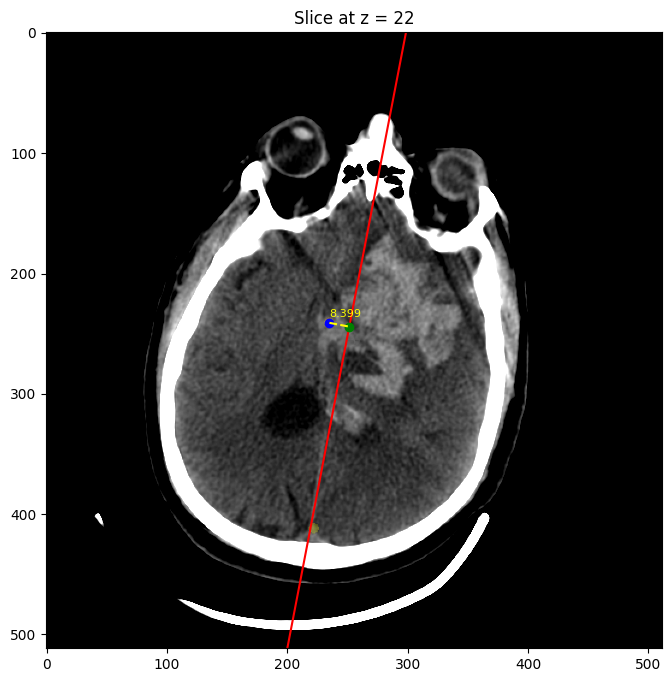

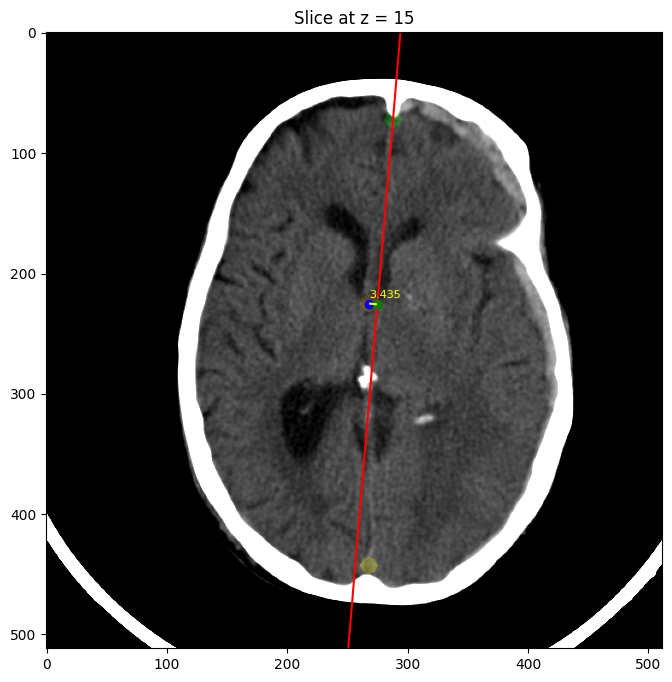

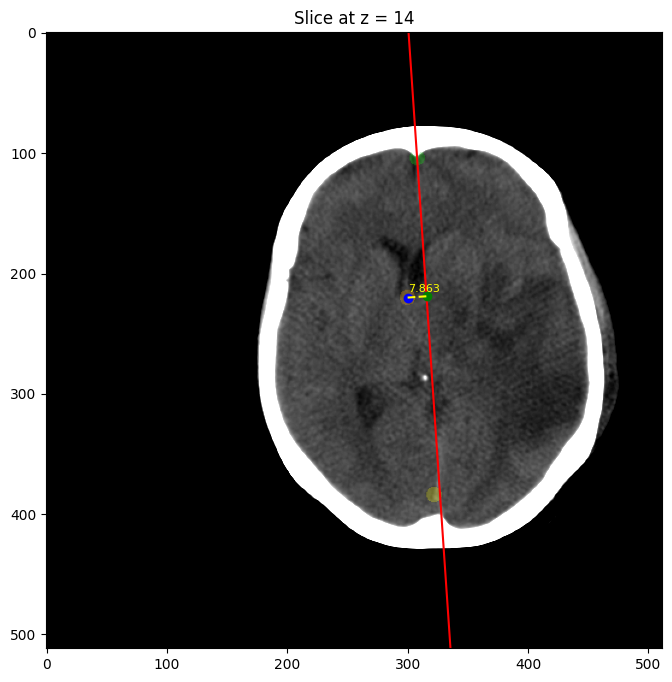

In [25]:
for i in range(0,len(IMAGE_PATHS)):
    calculate_midline_shift_mlsplotonly(i)